In [1]:
import sys
import os
import os.path as op

import numpy as np
import pandas as pd
import glob
import xarray as xr
import matplotlib.dates as mdates
from matplotlib import cm
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import great_circle_calculator.great_circle_calculator as gcc

# dev library
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..'))

# dependencies
#from lib import wrapSpectra, spectra, sat, plot_sat, model
from lib.config import * 
from lib.spectra import *

In [2]:
import warnings
warnings.filterwarnings("ignore")

# Dissipation of energy bins

Ardhuin et al. 2009
Range of variation in Peak wavelength and peak direction (50m and 20º)

In [3]:
# satellite
#ds_info = xr.open_dataset(op.join(p_output, 'ds_dataTracks.nc'))[['longitude', 'latitude']]
#ds_bins = xr.open_dataset(op.join(p_output, 'energy_BINS.nc'))[['distance']]
df_prop = pd.read_pickle(op.join(p_output, 'params_BINS.pkl'))#[['bearing_p1', 'H', 'Date']]

In [4]:
#ds_prop = xr.combine_by_coords([ds_prop, ds_bins, ds_info])

In [5]:
# count bins
time_ini, time_fin = forecast_day, forecast_day + datetime.timedelta(days=10)

bins_dirs = np.arange(0, 360, 5)
bins_date = pd.date_range(time_ini, time_fin, freq='3H')
bins_k = np.unique(df_prop.index.get_level_values(0))

In [6]:
#df_prop = ds_prop[['H', 'Date', 'longitude','latitude','distance', 'bearing_p1']].to_dataframe().dropna()
#df_prop = df_prop.reset_index().drop(columns=['file', 'nbox', 'posneg', 'dp'])

In [6]:
def count_bins(df, bins_dirs, bins_date, bins_k):
    
    df = df.reset_index()
    array_runners = []
    
    for pr, row in enumerate(bins_dirs[:-1]):
        for pc, col in enumerate(bins_date[:-1]):
            for pk, k in enumerate(bins_k[:-1]):
                sys.stdout.write('\r Dir {0}-{1} ; Date {2}-{3} ; K {4}-{5}'.format(pr, len(bins_dirs), pc, len(bins_date), pk, len(bins_k)))
                sys.stdout.flush()
                
                subset = df.loc[(df['bearing_p1'] >= row) & (df['bearing_p1'] < bins_dirs[pr+1]) &\
                                       (df.Date >= col) & (df.Date < bins_date[pc+1]) &\
                                                             (df.k >= k) & (df.k < bins_k[pk+1])]
                
                if not subset.empty:
                    ds = xr.Dataset(
                        {
                            'H': (('dirs', 'date', 'k','id'), subset['H'].values.reshape(1,1,1,-1)),
                            'distance': (('dirs', 'date', 'k','id'), subset['distance'].values.reshape(1,1,1,-1)),
                            'w':(('dirs', 'date', 'k', 'id'), subset['w'].values.reshape(1,1,1,-1)),
                            #'longitude': (('id'), df_run['longitude'].values),
                            #'latitude': (('id'), df_run['latitude'].values)
                        },
                        coords = {
                            'dirs':[row],
                            'date':[col],
                            'k': [k],
                            'id': range(len(subset))
                        }
                    )
                    array_runners.append(ds)
    
    ds_runners = xr.combine_by_coords(array_runners)
    return(ds_runners)

In [7]:
matrix = count_bins(df_prop, bins_dirs, bins_date, bins_k)

 Dir 70-72 ; Date 39-41 ; K 11-13

In [8]:
matrix.to_netcdf(op.join(p_output, 'runners_BINS.nc'), mode='w')

In [8]:
matrix = xr.open_dataset(op.join(p_output, 'runners_BINS.nc'))

___

## Interpretation of Swell Dissipation

In [9]:
# from meter to miles of kilometers
matrix['distance'] = matrix.distance / 1000

In [10]:
cm1 = cm.get_cmap('jet', 360)
colors = cm1(np.linspace(0,1, len(matrix.dirs)))

In [ ]:
# 6.3 ms-1 wind

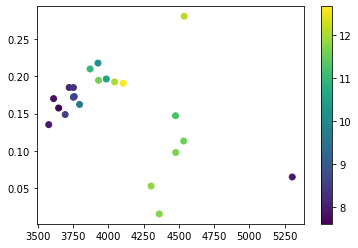

In [18]:
t = matrix.isel(date=10, dirs=10)
plt.scatter(t.distance, t.H, c=t.w)
plt.colorbar()

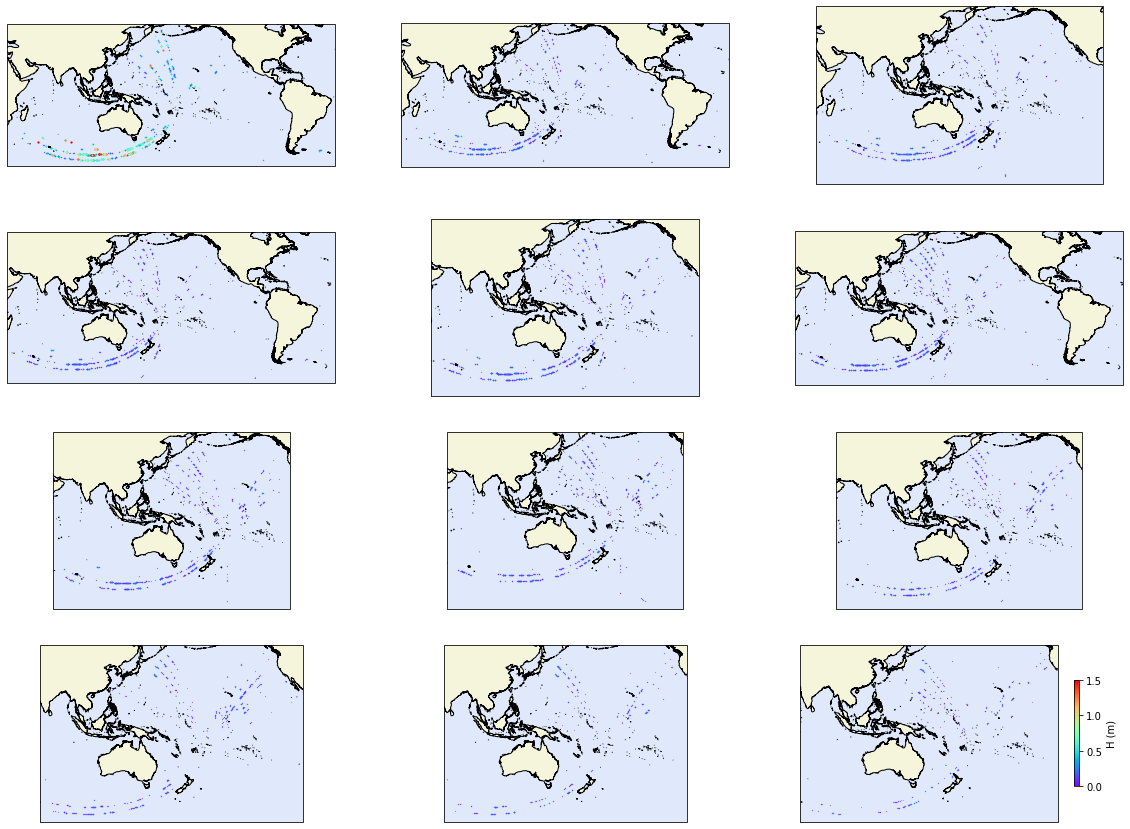

In [15]:
fig = plt.figure(figsize=[20,15])
i = 1
for pk, k in enumerate(matrix.k):
    
    sys.stdout.write('\r{0}'.format(i))
    sys.stdout.flush()
        
    ax = fig.add_subplot(np.ceil(len(matrix.k)/3), 3, i, projection=ccrs.PlateCarree(central_longitude=180))
    ax.patch.set_facecolor('cornflowerblue')
    ax.patch.set_alpha(0.2)
    ax.add_feature(shape_feature_l)
    ax.scatter(site_lon, site_lat, marker='*', c='w', s=5, transform = ccrs.PlateCarree())

    for pdir, dire in enumerate(matrix.dirs):
        for pdate, date in enumerate(matrix.date):

            dfk = matrix.isel(dirs=pdir, date=pdate, k=pk)
            dfk = dfk[['H', 'distance']].to_dataframe().dropna().reset_index()
            
            if not dfk.empty:

                # filter: observations spanning more than 3000 km
                range_distance = dfk.distance.max() - dfk.distance.min()

                if (len(dfk) > 4) & (range_distance > 3000):

                    for ix, (_, obs) in enumerate(dfk.iterrows()):
                        p2 = gcc.point_given_start_and_bearing([site_lon, site_lat], dire, obs.distance*1000, unit='meters') 
                        im = ax.scatter(p2[0], p2[1], c = obs.H, s=obs.H, vmin=0, vmax=1.5, cmap='rainbow', transform = ccrs.PlateCarree())
    i = i + 1
norm = cm.colors.Normalize(vmin=0, vmax=1.5)
fig.colorbar(cm.ScalarMappable(norm=norm, cmap='rainbow'), shrink=0.6, label='H (m)')
plt.show()

K 11 Dir 64 Date 39

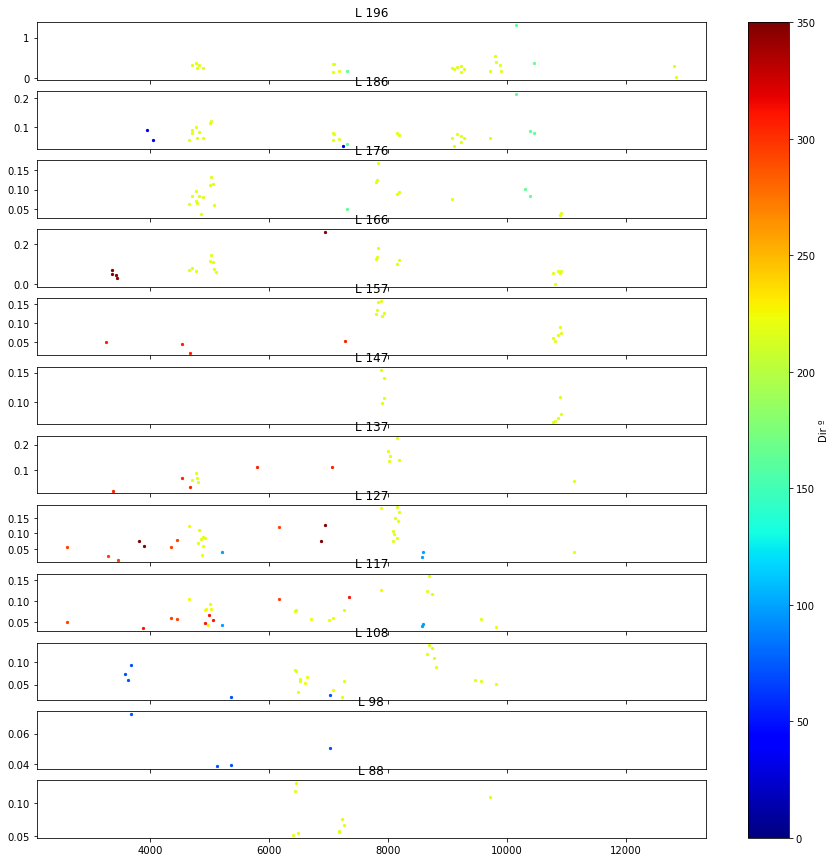

In [62]:
fig, axs = plt.subplots(len(bins_k)-1, figsize=(15,15), sharex=True)

for pk, k in enumerate(matrix.k):
    for pdir, dire in enumerate(matrix.dirs):
        for pdate, date in enumerate(matrix.date):

            sys.stdout.write('\rK {0} Dir {1} Date {2}'.format(pk, pdir, pdate))
            sys.stdout.flush()

            dfk = matrix.isel(dirs=pdir, date=pdate, k=pk)
            dfk = dfk[['H', 'distance', 'w']].to_dataframe().dropna().reset_index()
            dfk = dfk.loc[dfk['w'] < 10]
            
            # filter: observations spanning more than 3000 km
            range_distance = dfk.distance.max() - dfk.distance.min()
            
            if (len(dfk) > 2) & (range_distance > 3000):
                axs[pk].scatter(dfk.distance, dfk.H, color=colors[pdir], s=5)
                
                #xs, ys = dfk.distance/1000, dfk.H
                #coefficients = np.polyfit(np.log(xs), ys, 1)
                #y = coefficients[0]*np.log(xs) + coefficients[1]

                #axs[pk].plot(xs, y, c=colors[pdir], alpha=0.2)
            
    axs[pk].set_title('L {0}'.format(int(2*np.pi/k.values)))

norm = cm.colors.Normalize(vmin=0, vmax=matrix.dirs.max())
fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cm1), ax=axs.ravel().tolist(), label='Dir º')

plt.show()

In [51]:
df_ = matrix.where(matrix.w < 7).to_dataframe().dropna()

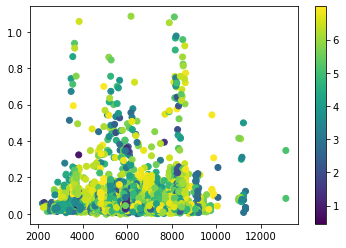

In [55]:
plt.scatter(df_.distance, df_.H, c=df_.w)
plt.colorbar()

In [ ]:
sys.exit()

In [ ]:
matrix = xr.open_dataset(op.join(p_output, 'runners_BINS.nc'))

In [ ]:
matrix

____

**Fit exponential dissipation curve**

In [ ]:
mdata = matrix.isel(date=0, dirs=0).to_dataframe().dropna()

In [ ]:
from scipy.optimize import curve_fit

def func(x, a, b):
    return a * np.exp(-b * x) 

In [ ]:
fig = plt.figure(figsize=(15,5))
for pk, k in enumerate(matrix.k.values):
    for pdate, date in enumerate(matrix.date.values):
        for pdir, dire in enumerate(matrix.dirs.values):
            
            mdata = matrix.isel(k=pk, date=pdate, dirs=pdir).dropna('id').to_dataframe()
            
            # filter to more than 3 observations and spanning more than 3000 km
            bigg_distance = mdata['distance'].max() - mdata['distance'].min()
            if (len(mdata['H']) > 3) & ((bigg_distance/1000) > 3000):
                xdata, ydata = (mdata.distance/1000)[::-1], mdata.H[::-1]
                popt, pcov = curve_fit(func, xdata, ydata)
                
                mdata = mdata.sort_values('distance')
                plt.plot(mdata['distance']/1000, mdata['H'], '.-')
                plt.plot(xdata, func(xdata, *popt), 'g--')
                
    sys.exit()
            

___